## 이항 분류
### EarlyStopping, ModelCheckpoint, Confusion Matrix, ROC curve
#### 0: White wine, 1: Red wine

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/wine' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

print(tf.__version__)

2.8.2


In [2]:
data = np.loadtxt('./wine.csv', delimiter=",", dtype=np.float64)
print(type(data))
print(data.shape)  # 6497행 13열

<class 'numpy.ndarray'>
(6497, 13)


In [3]:
X = data[:, 0:12]  # 0 ~ 11, 12개의 데이터 변수 추출
print(X.shape)     # 2차원 배열
Y = data[:, 12]    # 13번째 변수, class, 정답
print(Y.shape)     # 1차원 배열

(6497, 12)
(6497,)


In [21]:
# 데이터의 구성은 훈련, 검증, 테스트로 구성

In [4]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
# 데이터를 3그룹으로 분할: test 5% -> 95%(train 80%, validation 20%)
seed = 0
# stratify=Y: 0과 1의 분류 비율을 동일하게 데이터를 분할해줌.
# 95%: 분할대기(x_train_all), 5%: 테스트(x_test)
# x_train_all: 훈련 데이터 95% 분할 대기
# x_test: 테스트 데이터 5% 분할
# y_train_all: 훈련 target(class) 95% 분할 대기
# y_test: 테스트 target(class) 5% 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                  stratify=Y,
                                                  test_size=0.05,
                                                  random_state=seed)
# 나머지 데이터 95%를 분할, 80%: 훈련(x_train), 20%: 검증(x_val)
# x_train: 훈련 데이터 80% 분할
# x_val: 검증 데이터 20% 분할
# y_train: 훈련 target(class) 80% 분할
# y_val: 검증 target(class) 20% 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(y_train[0:100]) # 검증 Target 100건만 출력

(4937, 12)
(4937,)
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]


In [5]:
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(10, input_dim=12, activation='relu')) # 기울기 소실 방지
model.add(Dense(1, activation='sigmoid')) # True/False
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

# patience=5: 학습 결과가 개선되지 않아도 학습을 진행할 횟수
#             5번째도 증가시 학습 종료 
# restore_best_weights=True: 학4습 종료시 가장 우수한 가중치, 편향으로 저장
es= EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR): # 폴더가 존재하지 않으면 생성
    os.mkdir(MODEL_DIR) # 폴더 생성

# 03d: 좌측 0 padding 정수 3자리, .4f: 실수 소수점 4자리 
modelpath='./model/{epoch:03d}-{val_accuracy:.4f}.h5'  
# epoch:03d: 부족한 자리를 0으로 채우는 정수 형식
# val_accuracy:.4f: 소수이하 4째자리까지 표현 형식

# 검증 정확도가 개선되었을 때만 학습 모델 파일로 저장
# filepath=modelpath: 파일이 저장되는 경로와 파일명
# monitor='val_accuracy': 검증 정확도 기준으로 판단
# verbose=1: 기록되는 파일 정보 출력
# save_best_only=True: 검증 정확도가 개선되면 파일로 저장
mcp= ModelCheckpoint(filepath=modelpath,
                    monitor='val_accuracy',
                    verbose=1, save_best_only=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True,
                epochs=1000, batch_size=1, callbacks=[es, mcp])
end=time.time()
print('Runtime: {0:.0f} 초'.format(end-start))
# patience=5 i5 2320: 261s, i9-10900kf: i9-11900H 54s,
# Ryzen 7 2700X: 121s, Ryzen 5 3600: 54s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
4898/4937 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.9175
Epoch 1: val_accuracy improved from -inf to 0.92389, saving model to ./model\001-0.9239.h5
4937/4937 [==============================] - 6s 1ms/step - loss: 0.3510 - accuracy: 0.9182 - val_loss: 0.2721 - val_accuracy: 0.9239
Epoch 2/1000
4933/4937 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9380
Epoch 2: val_accuracy improved

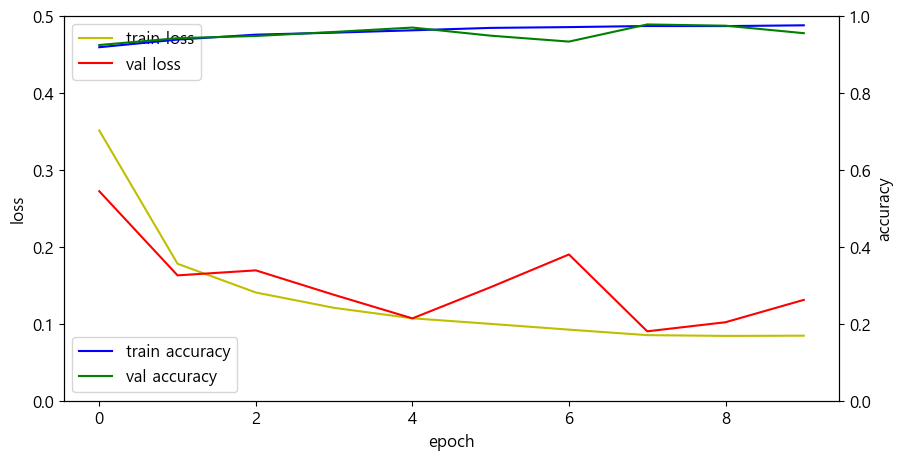

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [7]:
# verbose=0: 처리과정의 메시지 생략
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.0776124894618988 /정확도: 98.1538474559784 %


In [8]:
model = load_model('./model/022-0.9889.h5')
p = model.predict(x_test[0:100])
print(p.shape)
print(p[0:3])

(100, 1)
[[3.8184862e-06]
 [2.7455789e-07]
 [9.9047434e-01]]


In [9]:
for i in range(len(x_test[0:100])):
    fmt = '실제값: {0:.0f}, 예측값: {1}'
    print(fmt.format(y_test[i], np.round(p[i], 6)), end='')
    
    # 임계값의 지정, 정확도를 참고하여 판단, 60%이상 합격: 0.6
    if (p[i] >= 0.5): 
        print('--> Red 와인')   # 1
    else:
        print('--> White 와인') # 0

실제값: 0, 예측값: [4.e-06]--> White 와인
실제값: 0, 예측값: [0.]--> White 와인
실제값: 1, 예측값: [0.990474]--> Red 와인
실제값: 0, 예측값: [0.000793]--> White 와인
실제값: 1, 예측값: [0.999144]--> Red 와인
실제값: 1, 예측값: [0.996306]--> Red 와인
실제값: 0, 예측값: [0.00055]--> White 와인
실제값: 0, 예측값: [0.000686]--> White 와인
실제값: 0, 예측값: [0.492416]--> White 와인
실제값: 0, 예측값: [0.001513]--> White 와인
실제값: 1, 예측값: [0.99333]--> Red 와인
실제값: 0, 예측값: [0.002866]--> White 와인
실제값: 0, 예측값: [0.000199]--> White 와인
실제값: 1, 예측값: [0.998839]--> Red 와인
실제값: 0, 예측값: [0.000101]--> White 와인
실제값: 0, 예측값: [0.00437]--> White 와인
실제값: 0, 예측값: [0.00086]--> White 와인
실제값: 1, 예측값: [0.958844]--> Red 와인
실제값: 0, 예측값: [0.000316]--> White 와인
실제값: 1, 예측값: [0.999513]--> Red 와인
실제값: 0, 예측값: [3.5e-05]--> White 와인
실제값: 0, 예측값: [9.6e-05]--> White 와인
실제값: 0, 예측값: [7.1e-05]--> White 와인
실제값: 0, 예측값: [0.000412]--> White 와인
실제값: 1, 예측값: [0.995621]--> Red 와인
실제값: 0, 예측값: [7.2e-05]--> White 와인
실제값: 0, 예측값: [0.000137]--> White 와인
실제값: 1, 예측값: [0.999594]--> Red 와인
실제값: 0, 예측값: [0.002073]-->

In [10]:
red = 0
white = 0
for i in range(len(y_test)):
    if y_test[i] == 1:  # red wine 인지 검사
        red = red + 1
    else:
        white = white + 1

print('Red wine:', red)
print('White wine:', white)

Red wine: 80
White wine: 245


In [11]:
model.predict(x_test) # 0 ~ 1

array([[3.81848622e-06],
       [2.74557891e-07],
       [9.90474343e-01],
       [7.93188810e-04],
       [9.99144316e-01],
       [9.96306419e-01],
       [5.49644232e-04],
       [6.85781240e-04],
       [4.92415488e-01],
       [1.51291490e-03],
       [9.93329942e-01],
       [2.86608934e-03],
       [1.98692083e-04],
       [9.98838723e-01],
       [1.01219586e-04],
       [4.36955690e-03],
       [8.60035419e-04],
       [9.58844364e-01],
       [3.16172838e-04],
       [9.99512672e-01],
       [3.54563708e-05],
       [9.64275750e-05],
       [7.06969658e-05],
       [4.11748886e-04],
       [9.95620608e-01],
       [7.18533047e-05],
       [1.37448311e-04],
       [9.99594450e-01],
       [2.07310915e-03],
       [1.91402773e-06],
       [4.43011224e-02],
       [2.05904245e-04],
       [1.64213777e-03],
       [5.32546937e-01],
       [4.06054023e-05],
       [1.05973035e-01],
       [2.52394676e-02],
       [2.64460105e-05],
       [9.96792853e-01],
       [1.43113732e-03],


In [12]:
model.predict(x_test) >= 0.5 # True: Red wine, False: White wine

array([[False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [

In [13]:
(model.predict(x_test) >= 0.5).astype("int32") # True: 1, False: 0

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [14]:
# 결과 - 혼돈 행렬, # class 0우선으로 즉 오름차순으로 표가 생성
print(x_test.shape)

# 모델 테스트, Tensorflow 2.5까지 지원
# y_test_pred = model.predict_classes(x_test)  

# 모델 테스트, Tensorflow 2.6 이상 지원
y_test_pred = (model.predict(x_test) >= 0.5).astype("int32")  # 모델 테스트,
print(y_test_pred[:10])

(325, 12)
[[0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]


In [15]:
c_matrix = confusion_matrix(y_test, y_test_pred) # 실제값, 예측값
print(type(c_matrix))
print(c_matrix)

# [[0의 갯수        0이 아닌 갯수]
#  [ 1이 아닌 갯수       1의 갯수]]

# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

<class 'numpy.ndarray'>
[[244   1]
 [  2  78]]


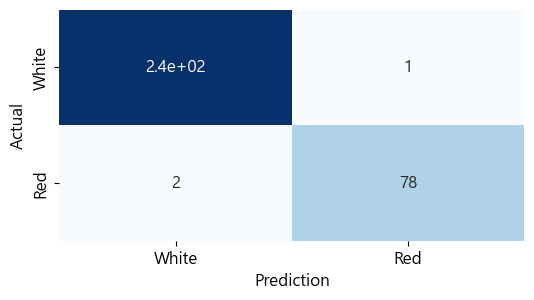

In [16]:
ax = sb.heatmap(c_matrix, annot=True, 
                 xticklabels=['White', 'Red'], 
                 yticklabels=['White', 'Red'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()

# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

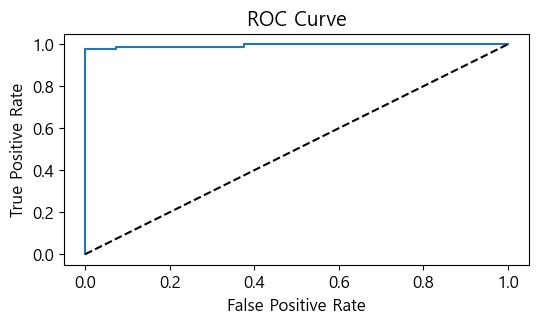

In [17]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(x_test)
# print(y_test_pred_probs)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()